In [1]:
#Modelo pré treinado VGG19
from keras.applications.vgg19 import VGG19
#Bibliotecas para plotar os filtros
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt
#Ferramentas para armazenar as ativações de uma determinada camada
from keras import models
#Algoritmos de PCA
from sklearn.decomposition import FastICA
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
#Pre processamento da imagem para ser passada para a rede
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg19 import decode_predictions
#SOM
from minisom import MiniSom
#----------------------------------

#Carrega o modelo ja treinado
model = VGG19()
model.summary()
#Imprime os nomes das camadas e o seu indice no arraay de ativações
j=0
for i in model.layers[1:]:
    print(j, ' ', i.name)
    j+=1

Using TensorFlow backend.
/home/gustavo/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/gustavo/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/gustavo/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/gustavo/.local/lib/python3.6/site-packages/tensorflow/py

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
bloc

In [2]:
#----------------------------------------------------------------
#Função que aplica o PCA em um array de ativações 
##patterns-array de ativações
##num_comp-numero de componentes do PCA
##pca-tipo de algoritmo ( Fast ICA = 0, PCA = 1 (default))
def dimRed(patterns, num_comp, pca = 1):
    maps = []
    # Initialize the algorithm and set the number of PC's
    if(pca == 0) :
        dim_red = FastICA(n_components=num_comp)
    else:
        dim_red = PCA(n_components=num_comp)

    # Fit and transform the model to data. It returns a list of independent components 
    for aux in patterns:
        aux = dim_red.fit_transform(aux)

        f_min, f_max = np.amin(aux), np.amax(aux)
        aux = (aux - f_min) / (f_max - f_min)
        
        maps.append(aux)
    print(len(maps[0]), 'x', len(maps[0][0]))
    return maps
#------------------------------------------------------------------------------------------------
#Reduz a dimensionalidade de um array de ativações em 2(cada eixo é reduzido à metade)
##patterns-array de ativações
##typ-tipode pooling('max'-elemento máximo(default), 'mean'-media aritimética)
def Pooling(patterns, typ = 'max'):
    patterns_N =[]
    for pat_aux in patterns:
        red_patterns = np.empty((int(pat_aux.shape[0]/2), int(pat_aux.shape[1]/2)))
        l=0
        for i in range(0, pat_aux.shape[0], 2):
            c=0
            for j in range(0, pat_aux.shape[1], 2):
                if(typ == 'max'):
                    red_patterns[l][c] = max(pat_aux[i][j], pat_aux[i+1][j], pat_aux[i][j+1], pat_aux[i+1][j+1])
                elif(typ == 'mean'):
                    red_patterns[l][c] = (pat_aux[i][j] + pat_aux[i+1][j] + pat_aux[i][j+1] + pat_aux[i+1][j+1])/4
                c+=1
            l+=1
        patterns_N.append(red_patterns)
    print(len(red_patterns), 'x', len(red_patterns[0]))
    return patterns_N
#-----------------------------------------------------------------------------------------------
#Duplica a dimensionalidade de um array de ativações(cada eixo tem sua dimensão dobrada)
##patterns-array de ativações
def invPooling(patterns):
    patterns_N =[]
    for pat_aux in patterns:
        red_patterns = np.empty((int(pat_aux.shape[0]*2), int(pat_aux.shape[1]*2)))
        l=0
        for i in range(0, pat_aux.shape[0], 1):
            c=0
            for j in range(0, pat_aux.shape[1], 1):
                red_patterns[l][c] = pat_aux[i][j];
                red_patterns[l+1][c] = pat_aux[i][j];
                red_patterns[l][c+1] = pat_aux[i][j];
                red_patterns[l+1][c+1] = pat_aux[i][j];
                c+=2
            l+=2
        patterns_N.append(red_patterns)
    print(len(red_patterns), 'x', len(red_patterns[0]))
    return patterns_N
#----------------------------------------------------------------------------------------------
def printPatterns(patterns, tittles, prob):
    j=1
    for i in range(len(patterns)):
        to_plot = patterns[i]
        plt.subplot(len(patterns), 11, j)
        plt.imshow(to_plot, cmap='hot')
        j+=1
        plt.title(tittles[i]+' - '+prob[i]+'%')
    plt.subplots_adjust(left=0, bottom=0, right=5, top=25, wspace=0.2, hspace=0.2)
    plt.show()
#---------------------------------------------------------------------------------------------    
def printMaps(maps, tittles, prob, l, c):
    j=1
    for i in range(len(maps)):
        to_plot = maps[i]
        to_plot = to_plot.reshape((l, c))
        plt.subplot(len(maps), 6, j)
        plt.imshow(to_plot, cmap='hot')
        j+=1
        plt.title(tittles[i]+' - '+prob[i]+'%')
    plt.subplots_adjust(left=0, bottom=0, right=3, top=15, wspace=0.2, hspace=0.05)
    plt.show()

In [3]:
layer_outputs = [layer.output for layer in model.layers[1:] ]
# Extracts the outputs of the top 12 layers
activation_model = models.Model(inputs=model.input, outputs=layer_outputs) 
# Creates a model that will return these outputs, given the model input

In [4]:
imgs = ('elephant1.jpeg', 'elephant2.jpeg', 'elephant3.jpeg', 'elephant4.jpeg', 'plumbus.webp', 'plumbus2.jpeg', 'pneu.jpeg', 'pneu2.jpeg', 
        'caneca1.jpg', 'caneca2.jpeg', 'caneca3.jpg', 'caneca4.jpeg', 'deer.jpg', 'deer2.jpeg', 'impala.jpeg', 'deer3.jpeg', 'aviao1.jpeg', 
        'aviao2.jpeg', 'car1.jpeg', 'car2.jpeg', 'esquilo1.jpeg', 'esquilo2.jpeg', 'rato1.jpeg', 'rato2.jpeg', 'pessoa1.jpeg', 'pessoa2.jpeg',
       'sand1.jpeg', 'sand2.jpeg', 'girafa1.jpeg', 'girafa2.jpeg', 'girafa3.jpeg', 'girafa4.jpeg', 'girafa5.jpeg', 'girafa6.jpeg', 'girafa7.jpeg', 
        'zeb_gir.jpeg', 'mesa_comp.jpg', 'passaro1.jpeg', 'polvo1.jpg', 'polvo2.jpg', 'passaro_comp.png', 'cena.jpeg', 'plateia.jpg', 'A.jpeg')

In [5]:
layer = 15
layer_red = 20
img_plot = []
patterns = []
patterns_red = []
tittles = []
prob = []
for i in imgs:
    img_aux = load_img('images/'+i, target_size=(224, 224))
    img_aux = img_to_array(img_aux)
    img_plot.append(img_aux)
    img_aux = img_aux.reshape((1, img_aux.shape[0], img_aux.shape[1], img_aux.shape[2]))
    #img_aux = preprocess_input(img_aux)
    
    acts = activation_model.predict(img_aux)
    pred_aux = acts[layer]
    pred_aux_red = acts[layer_red]
    f_min, f_max = np.amin(pred_aux), np.amax(pred_aux)
    f_min_red, f_max_red = np.amin(pred_aux_red), np.amax(pred_aux_red)
    pred_aux = (pred_aux - f_min) / (f_max - f_min)
    pred_aux_ = (pred_aux_red - f_min_red) / (f_max_red - f_min_red)
    
    patterns.append(pred_aux[0].reshape((392,256)))
    patterns_red.append(pred_aux_red[0].reshape((196,128)))
    
    label = model.predict(img_aux)
    label = decode_predictions(label)
    label = label[0][0]
    tittles.append(label[1])
    prob.append(str(int(label[2]*100)))

In [6]:
maps_1 = dimRed(patterns, 1)
maps_red_1 = dimRed(patterns_red, 1)

392 x 1
196 x 1


In [7]:
patterns = Pooling(patterns)
patterns_red = Pooling(patterns_red)

196 x 128
98 x 64


In [8]:
maps = dimRed(patterns, 1)
maps_red = dimRed(patterns_red, 1)

196 x 1
98 x 1


In [9]:
patterns = Pooling(patterns)
patterns_red = Pooling(patterns_red)

98 x 64
49 x 32


In [10]:
maps = dimRed(patterns, 1, 1)
maps_red_ = dimRed(patterns_red, 1, 1)

98 x 1
49 x 1


In [14]:
maps_img = []
for aux in maps:
    maps_img.append(aux.reshape((7, 14)))
for i in range(4):
    maps_img = invPooling(maps_img)
    
maps_red_img = []
for aux in maps_red:
    maps_red_img.append(aux.reshape((7, 14)))
for i in range(5):
    maps_red_img = invPooling(maps_red_img)
    

14 x 28
28 x 56
56 x 112
112 x 224
14 x 28
28 x 56
56 x 112
112 x 224
224 x 448


In [15]:
filtros_ref = []
for i in range(len(maps_img)):
    filtros_ref.append((0.3*maps_img[i]+0.7*maps_red_img[i])*maps_img[i])
printMaps(filtros_ref, tittles, prob, 224, 224)

ValueError: operands could not be broadcast together with shapes (112,224) (224,448) 

In [44]:
'''
from skimage.color import rgb2grey
img_grey = []
for aux in img_plot:
    img_grey.append(rgb2grey(aux))
'''

'\nfrom skimage.color import rgb2grey\nimg_grey = []\nfor aux in img_plot:\n    img_grey.append(rgb2grey(aux))\n'

In [45]:
'''
img_sobreposta = []
for i in range(len(img_grey)):
    img_sobreposta.append(img_grey[i]*filtros_ref[i])
'''

'\nimg_sobreposta = []\nfor i in range(len(img_grey)):\n    img_sobreposta.append(img_grey[i]*filtros_ref[i])\n'

In [46]:
#printMaps(img_sobreposta, tittles, prob, 224, 224)

In [47]:
maps_input = filtros_ref
for i in range(4):
    maps_input = Pooling(maps_input)

112 x 112
56 x 56
28 x 28
14 x 14


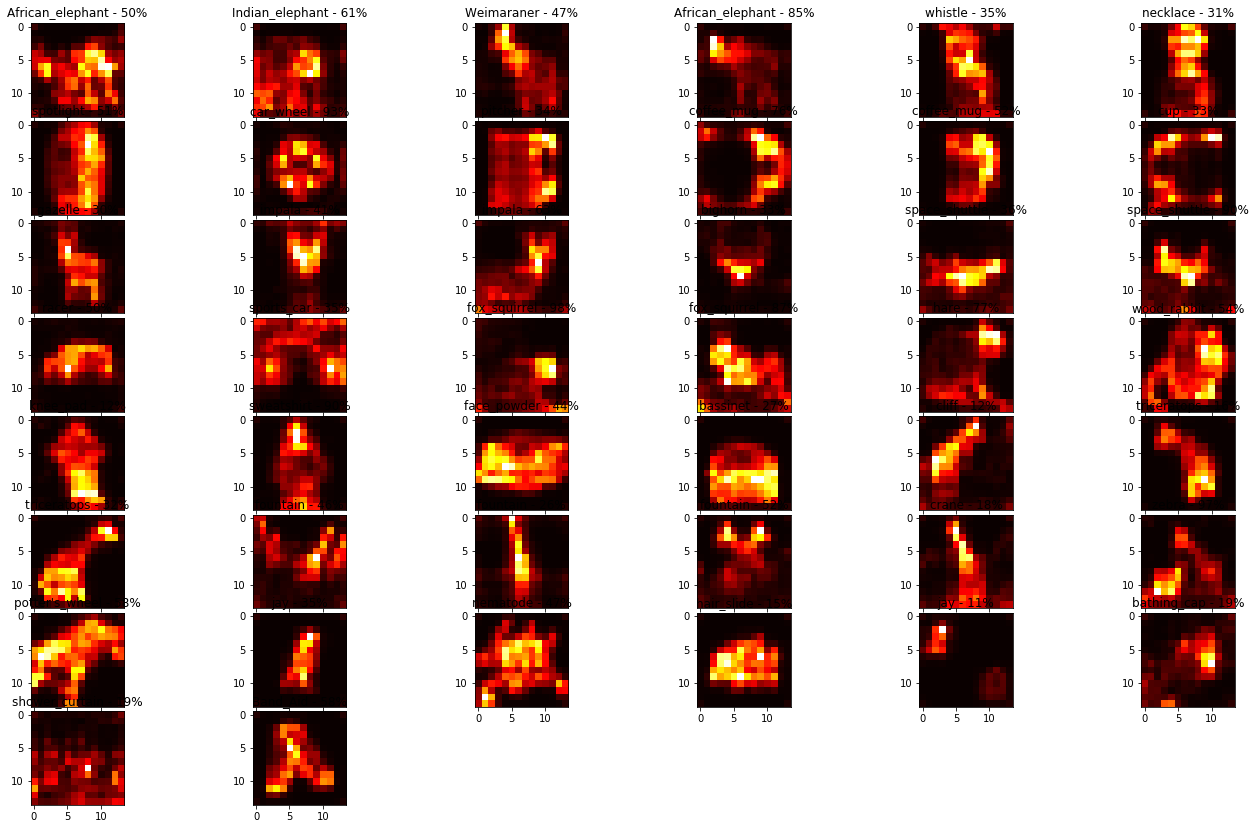

In [48]:
printMaps(maps_input, tittles, prob, 14, 14)
som_input = []
for i in patterns_red_3:
    som_input.append(i.reshape((len(i)*len(i[0]))))
size = len(i)*len(i[0])

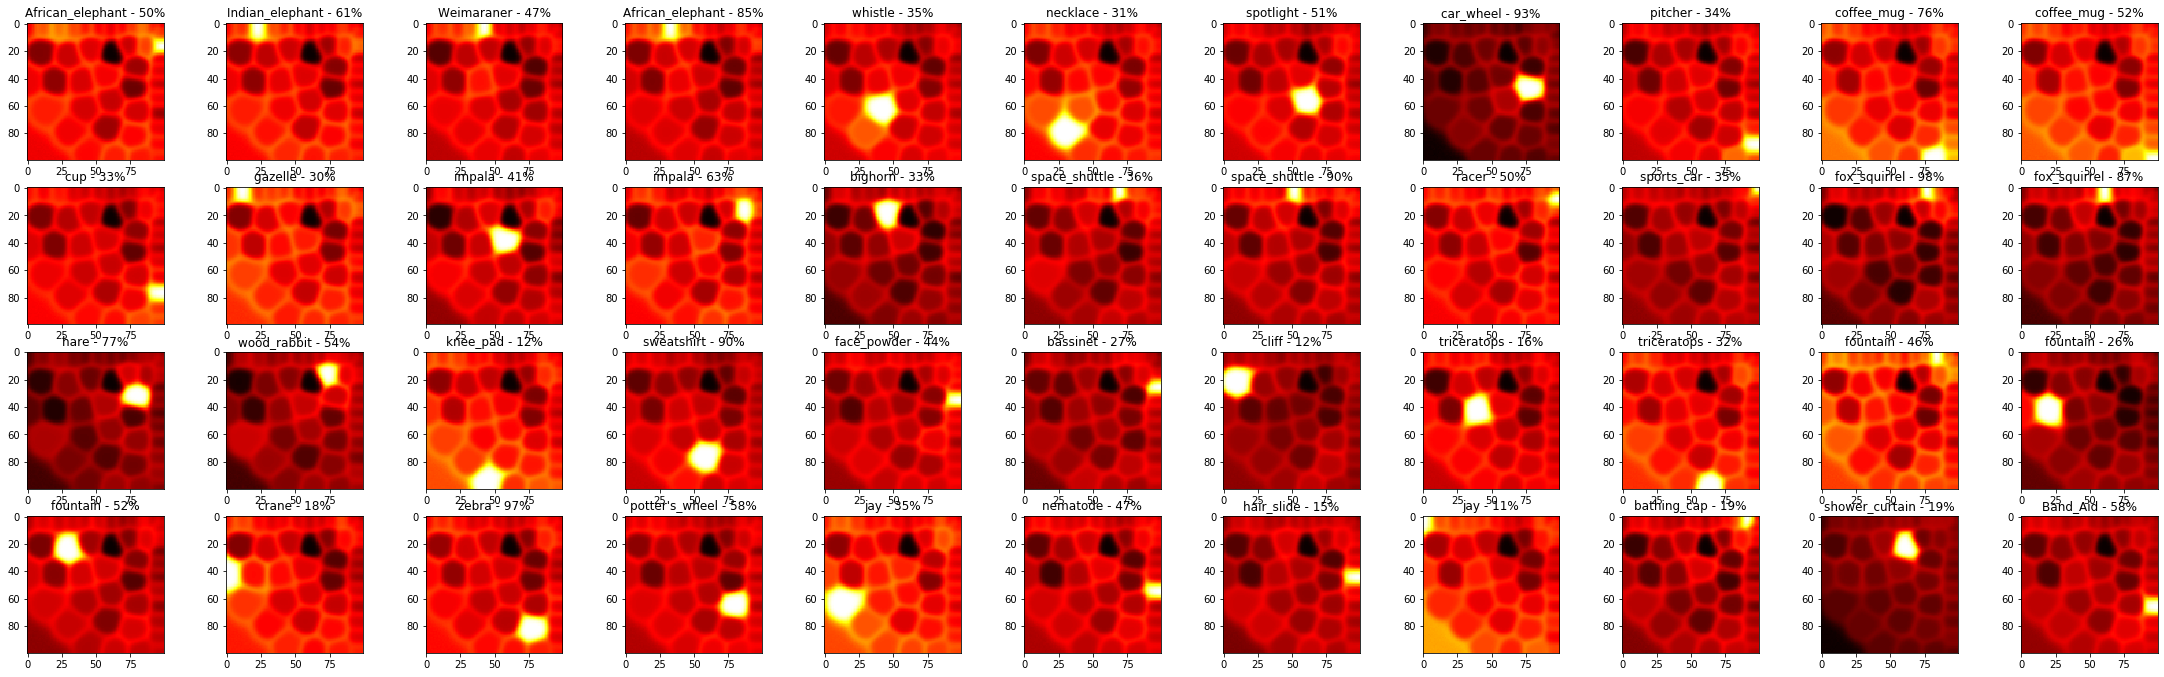

In [53]:
dim = 100
som = MiniSom(dim, dim, size, sigma=6.5, learning_rate=0.05)
som.train(som_input, 30000)

locations = []
for aux in som_input:
    locations.append(som.activate(aux))

for i in range(len(locations)):
    locations[i] = 1-locations[i]
    f_min, f_max = np.amin(locations[i]), np.amax(locations[i])
    locations[i] = (locations[i] - f_min) / (f_max - f_min)
    
    #for j in range(dim):
    #    for k in range(dim):
    #        if(locations[i][j][k] < 0.8): locations[i][j][k] = 0
    
printPatterns(locations, tittles, prob)